The purpose of this notebook is to develop architecture and utilities for fit neural network on B → J reconstruction problem.

In [12]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from IPython.display import display, clear_output

In [14]:
import sys
sys.path.append('../../..')

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from magrec.prop.Fourier import FourierTransform2d
from magrec.prop.Kernel import HarmonicFunctionComponentsKernel, MagneticFieldToCurrentInversion2d
from magrec.prop.Propagator import CurrentPropagator2d, AxisProjectionPropagator
from magrec.misc.plot import plot_n_components
from magrec.nn.arch import GeneratorCNN
from magrec import __datapath__

In [16]:
from magrec.misc.load import load_matlab_data

In [17]:
# experimental data where three components of the magnetic field are measured above an Nb wire
# data is from DOI: 10.1103/PhysRevApplied.14.024076
Bx = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "Bx.txt")
By = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "By.txt")
Bz = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "Bz.txt")

B = torch.tensor(np.array([Bx, By, Bz]), dtype=torch.float32)

dx = 0.408  # in μm
dy = 0.408

height = 0.015          # μm
layer_thickness = 0.030 # μm

# this is an axis along which the magnetic field is *usually* measured
# in this case we will project the measured components to simulate such case
theta = 54.7            # degrees
phi = 45.0              # degrees

# Neural net architecture

In [18]:
from magrec.prop.Pipeline import (
    Pipe,
    HannFilter, 
    GaussianFilter,
    Union, 
    PlotResults, 
    FourierZeroDivergenceConstraint2d, 
    CurrentLayerToField, 
    Projection, 
    Sandwich, 
    Padder, 
    Function,
)

from magrec.scripts.prototype_pipeline import Prototype

from magrec.nn.arch import UNet, BnCNN

In [19]:
from magrec.scripts.prototype_pipeline import Prototype

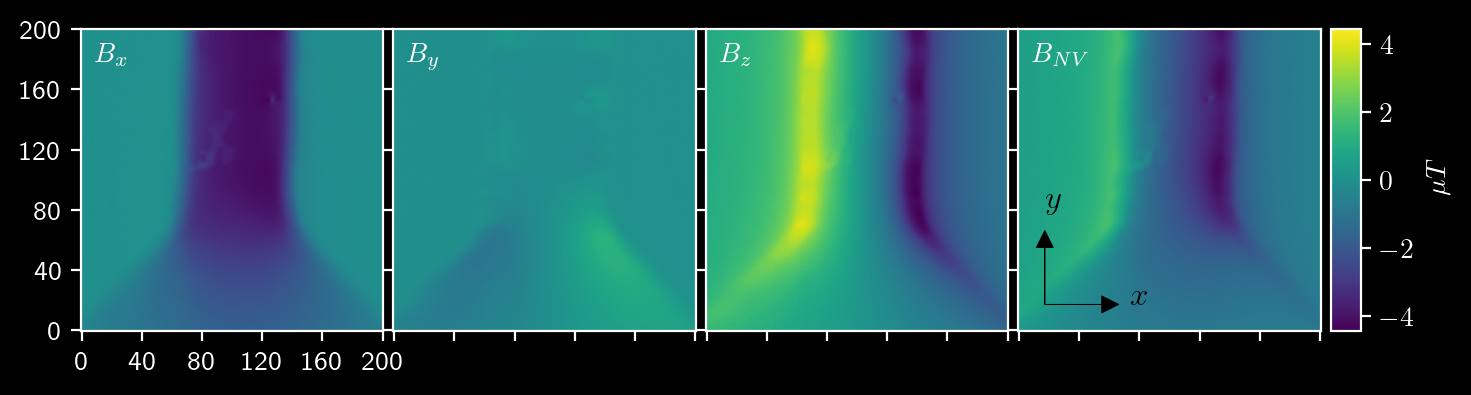

In [61]:
pipe = Pipe([  
    # NV stands for nitrogen-vacancy (its a quantum defect in diamond crystal used for measuring magnetic field and quantum computing)
    ('B+B_NV', Union([
        ('B', 'passthrough'),
        ('B_NV', Projection(theta=theta, phi=phi)),
    ], dim=-3)),
    ('plot1', PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], units=r"$\mu T$")),
    ('B_NV', Function(lambda x: x[None, [-1], :, :])),
    ('padded_B_NV', Padder(up_to=(16*20, 16*20))),
])

pipe.fit(B).transform(B);

model = Pipe([
    # ('JxJy', Union([('Jx', FourierZeroDivergenceConstraint2d()), ('Jy', 'passthrough')], dim=-3)),
    ('plot1', PlotResults(labels=[r"$J_x$", r"$J_y$"], units=r"mA/m$^2$")),
    ('B', CurrentLayerToField(dx=dx, dy=dy, height=height, layer_thickness=layer_thickness)),
    ('B+B_NV', Union([('B', 'passthrough'), ('B_NV', Projection(theta=theta, phi=phi))], dim=-3)),
    ('plot2', PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], units=r"$\mu T$")),
    ('B_NV', Function(lambda x: x[..., [-1], :, :])),
])

recon = Prototype(
    net=BnCNN, 
    model=model, 
    pipe=pipe, 
    max_epochs=20, 
    n_channels_in=1, 
    n_channels_out=2
    )

  epoch    train_loss       dur
-------  ------------  --------
      1      2.44e+00  1.62e-01
     20      9.46e-01  1.61e-01


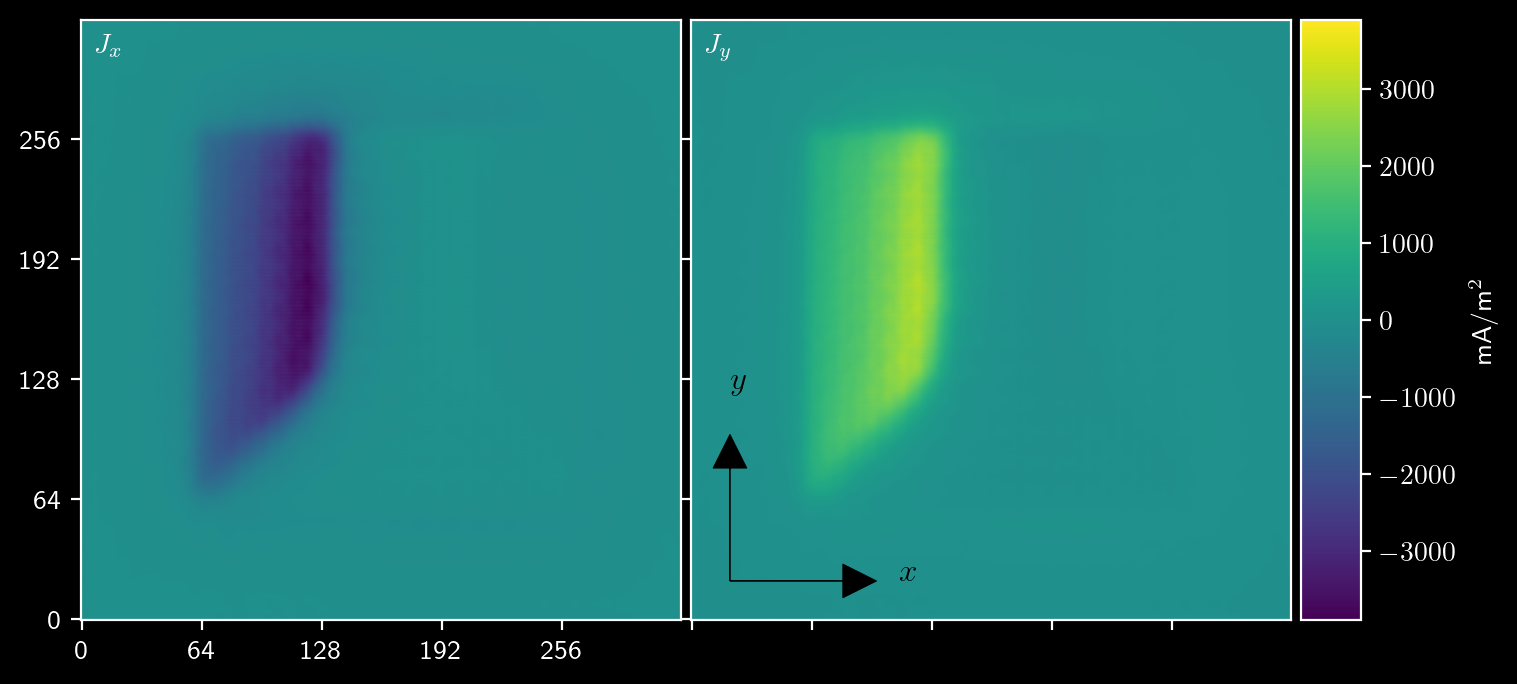

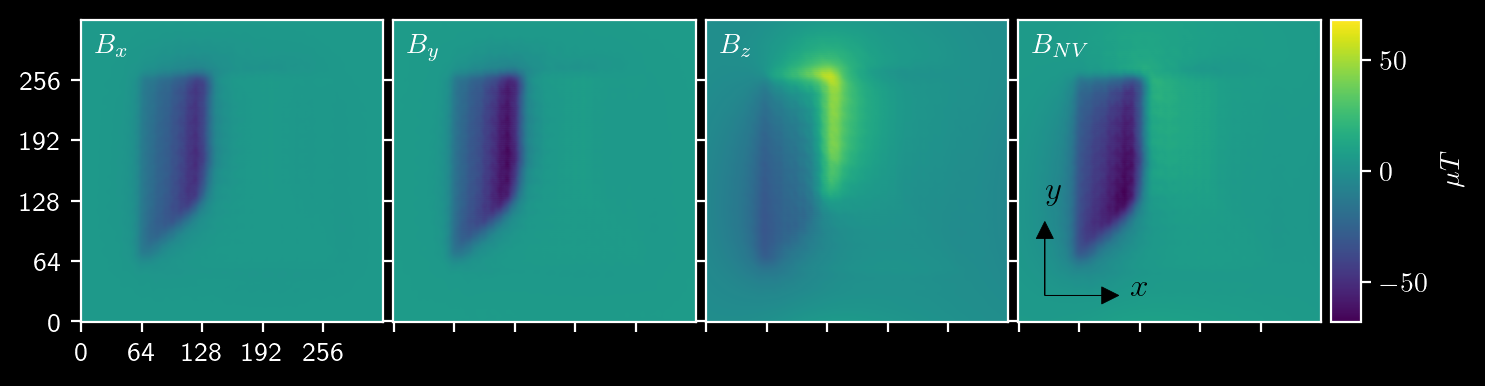

tensor([[[[5.9587, 5.9378, 5.9184,  ..., 5.9956, 5.9855, 5.9748],
          [5.9520, 5.9337, 5.9120,  ..., 5.9877, 5.9753, 5.9653],
          [5.9481, 5.9297, 5.9107,  ..., 5.9821, 5.9669, 5.9582],
          ...,
          [5.9935, 5.9800, 5.9656,  ..., 6.0269, 6.0126, 6.0061],
          [5.9849, 5.9688, 5.9524,  ..., 6.0195, 6.0057, 5.9979],
          [5.9739, 5.9571, 5.9401,  ..., 6.0115, 5.9993, 5.9894]]]],
       grad_fn=<IndexBackward0>)

In [62]:
recon.propagate(B, epochs=20, print_log_every=20, callbacks__print_log__floatfmt=".2e", lr=0.1)

# Masks

Masks are difficult, because they need to be expanded according to the size of the input. 

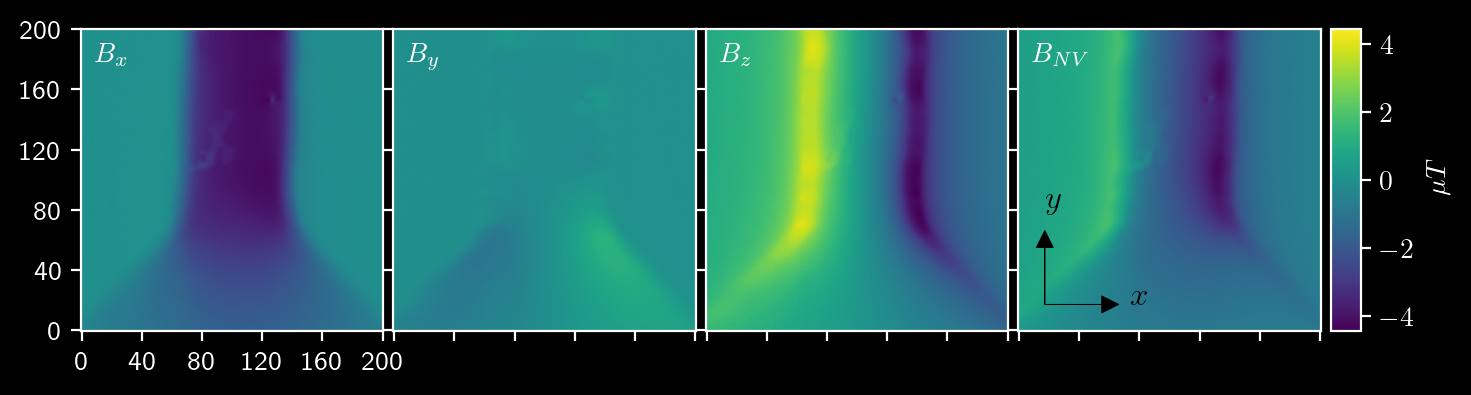

In [80]:
padder = Padder(up_to=(16*20, 16*20))

pipe = Pipe([  
    # NV stands for nitrogen-vacancy (its a quantum defect in diamond crystal used for measuring magnetic field and quantum computing)
    ('B+B_NV', Union([
        ('B', 'passthrough'),
        ('B_NV', Projection(theta=theta, phi=phi)),
    ], dim=-3)),
    ('plot1', PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], units=r"$\mu T$")),
    ('B_NV', Function(lambda x: x[None, [-1], :, :])),
    ('padded_B_NV', padder),
])

pipe.fit(B).transform(B);

padding = padder.padding
threshold = -0.2
mask = torch.where(B[0] < threshold, torch.ones_like(B[0]), torch.zeros_like(B[0]))
mask = torch.nn.functional.pad(mask, (padding[-1], padding[-2], 0, 0), mode='constant', value=1.0)
mask = torch.nn.functional.pad(mask, (0, 0, padding[-3], padding[-4]), mode='constant', value=0.0)
def apply_mask(x):
    masked_x = mask * x
    return masked_x

mask_fn = Function(apply_mask)

model = Pipe([
    ('plot1', PlotResults(labels=[r"$J_x$", r"$J_y$"], units=r"mA/m$^2$")),
    ('mask', mask_fn),
    ('B', CurrentLayerToField(dx=dx, dy=dy, height=height, layer_thickness=layer_thickness)),
    ('B+B_NV', Union([('B', 'passthrough'), ('B_NV', Projection(theta=theta, phi=phi))], dim=-3)),
    ('plot2', PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], units=r"$\mu T$")),
    ('B_NV', Function(lambda x: x[..., [-1], :, :])),
])

recon = Prototype(
    net=UNet, 
    model=model, 
    pipe=pipe, 
    max_epochs=20, 
    n_channels_in=1, 
    n_channels_out=2
    )

In [81]:
recon.propagate(B, epochs=20, print_log_every=20, callbacks__print_log__floatfmt=".2e", lr=0.1)

TypeError: unsupported operand type(s) for *: 'Function' and 'Tensor'

In [69]:
padder.pad

NameError: name 'padder' is not defined